In [1]:
%pylab inline

import scanpy as sc
import pandas as pd
from pysctransform.pysctransform import vst
from pysctransform.plotting import plot_fit, plot_residual_var, compare_with_sct

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%capture

fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

# Log Normalization

In [3]:
adata = sc.read_h5ad("../data/pbmc3k.h5ad")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
_ = sc.pl.umap(adata, color=["leiden"], legend_loc="on data", ax=ax1, show=False)

# SCT (glmGamPoi)

In [5]:
# Input is gene x cell
pbmc3k = sc.read_h5ad("../data/pbmc3k.h5ad")
vst_glmgp_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="glmgp",
    n_cells=None,
    n_genes=2000,
)
gene_attr = vst_glmgp_3k["gene_attr"]
gene_attr = gene_attr.sort_values(by=["residual_variance"], ascending=False)
highly_variable = gene_attr.index[:3000].tolist()

clip_range = [-np.sqrt(pbmc3k.shape[0]/30), 
              np.sqrt(pbmc3k.shape[0]/30)]

residuals = vst_glmgp_3k["residuals"].T[highly_variable]
residuals = np.clip(residuals, clip_range[0], clip_range[1])
pbmc3k.obsm["pearson_residuals_glmgp3"] = residuals

X_pca = sc.pp.pca(pbmc3k.obsm["pearson_residuals_glmgp3"])

pbmc3k.obsm["X_pca_glmgp3"] = X_pca
sc.pp.neighbors(pbmc3k, use_rep="X_pca_glmgp3")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.leiden(pbmc3k)
_ = sc.pl.umap(pbmc3k, color=["leiden"], legend_loc="on data", ax=ax2, show=False)

# SCT (theta_ml)

In [6]:
pbmc3k = sc.read_h5ad("../data/pbmc3k.h5ad")

vst_thetaml_3k = vst(
    pbmc3k.X.T,
    gene_names=pbmc3k.var_names.tolist(),
    cell_names=pbmc3k.obs_names.tolist(),
    method="theta_ml",
    n_cells=None,
    n_genes=2000,
)
gene_attr = vst_thetaml_3k["gene_attr"]
gene_attr = gene_attr.sort_values(by=["residual_variance"], ascending=False)
highly_variable = gene_attr.index[:3000].tolist()
clip_range = [-np.sqrt(pbmc3k.shape[0]/30), 
              np.sqrt(pbmc3k.shape[0]/30)]

residuals = vst_thetaml_3k["residuals"].T[highly_variable]
residuals = np.clip(residuals, clip_range[0], clip_range[1])
pbmc3k.obsm["pearson_residuals_thetaml"] = residuals

X_pca = sc.pp.pca(pbmc3k.obsm["pearson_residuals_thetaml"])
pbmc3k.obsm["X_pca_thetaml"] = X_pca





sc.pp.neighbors(pbmc3k, use_rep="X_pca_thetaml")
sc.tl.umap(pbmc3k, min_dist=0.3)
sc.tl.leiden(pbmc3k)
_ = sc.pl.umap(pbmc3k, color=["leiden"], legend_loc="on data", ax=ax3, show=False)

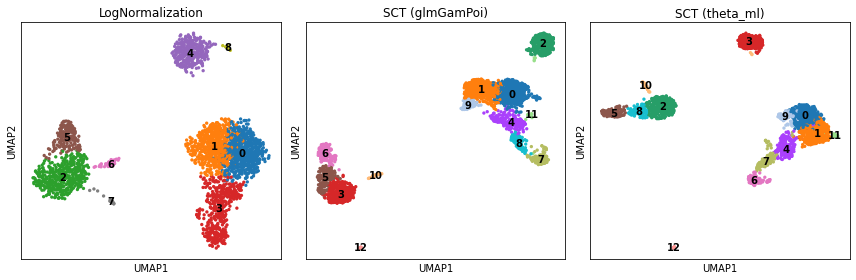

In [7]:
_ = ax1.set_title("LogNormalization")
_ = ax2.set_title("SCT (glmGamPoi)")
_ = ax3.set_title("SCT (theta_ml)")
fig.tight_layout()
fig